In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/nlp_sentiment/

/content/gdrive/MyDrive/nlp_sentiment


In [ ]:
import torch
import pandas as pd
import seaborn as sns


In [ ]:
train = pd.read_csv('drop_na_cleaned_train.csv')
test = pd.read_csv('test.csv')

In [ ]:
##데이터 구성 확인
train.head()

,sentiment,cleaned_text
0,neutral,responded
1,negative,sooo miss diego
2,negative,bos bullying
3,negative,interview leave alone
4,negative,son couldnt release already bought


In [ ]:
## null 값 확인 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27079 entries, 0 to 27078
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sentiment     27079 non-null  object
 1   cleaned_text  27079 non-null  object
dtypes: object(2)
memory usage: 423.2+ KB


In [ ]:
## train에서 null을 포함하는 행이 1개 뿐이고 핵심이 되는 데이터이므로 제거 
train.dropna(axis=0, inplace=True) 

In [ ]:
## train에서 null 값이 제대로 제거 되었는지 확인 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27079 entries, 0 to 27078
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sentiment     27079 non-null  object
 1   cleaned_text  27079 non-null  object
dtypes: object(2)
memory usage: 634.7+ KB


In [ ]:
## test에서 null을 포함하는 행을 확인 -> 없으므로 그냥 넘어감 -> 있더라도 null 값을 별도의 값으로 채워줘야지 제거해서는 안 됨 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [ ]:
import re

def clean_punc(text) :
  cleaned_text = re.sub(r'[^\w\s]','',text)
  cleaned_text = re.sub(r'[0-9]','',cleaned_text)
  return cleaned_text

In [ ]:
import numpy as np

#np.vectorize(user_defined_function) -> vectorize 된 사용자 정의 함수 return  
#                                    -> 성능이 아닌 사용자 편의를 위해 제공된 함수 
#                                    -> scalar를 입력으로 받는 user_defined_function이 vector에 적용될 수 있게 만들어 줌 

vectorized_clean_punc = np.vectorize(clean_punc)
train['cleaned_ztext'] = vectorized_clean_punc(train["cleaned_text"])
test['cleaned_text'] = vectorized_clean_punc(test["text"])

In [ ]:
# Remove stopwords 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
train['cleaned_text'] = train['cleaned_text'].apply(lambda x : " ".join([w.lower() for w in x.split() if w not in stop_words and len(w) > 3]))
test['cleaned_text'] = test['cleaned_text'].apply(lambda x : " ".join([w.lower() for w in x.split() if w not in stop_words and len(w) > 3]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Tokenize 
texts_train = train["cleaned_text"].apply(lambda x : x.split())
texts_test = test["cleaned_text"].apply(lambda x : x.split())

In [ ]:
# Lemmatize (표제어 추출 -> 표제어 = 사전에 나타나는 형태의 단어) -> 정규화를 통해 입력의 복잡성을 단순화하고자 하는 방법 
# Lemmatize 외에도 Stemming(어간 추출)의 방법이 존재 -> Stemming은 원래 형태를 보존하려고 하는 반면 Lemmatize는 원래 형태에 상관 없이 사전에 나오는 형태에 최대한 가까운 형태로 만들어줌 
#                                                    -> 때로는 이로 인해 원래 의미와 다른 의미의 단어로 만들어 버리는 경우가 있어 이러한 경우에는 Lemmatize 대신에 Stemming을 사용해야 함 
# 위와 같은 정규화 방법을 사용하려고 할 때는 항상 일반화의 정도에 대해 신경써야함 -> 지나치게 일반화 되는 것도 좋지 않고 일반화가 덜 되는 것도 좋지 않음 
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

lemma = WordNetLemmatizer()
lemmatized_train_text = texts_train.apply(lambda x : [lemma.lemmatize(w) for w in x])
lemmatized_test_text = texts_test.apply(lambda x : [lemma.lemmatize(w) for w in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
label_common_words = set(['good','like','today','time','really','going','work','well','know','back','dont','cant'])
enr_common_words = set(['today','tomorrow','monday','sunday','yesterday','friday','saturday','summer','weekend','next week','month','last year','day','next month','next weekend', 'thursday', 'morning','hour','earlier today','another hour'])
lda_common_words = set(['like'])

words_to_delete = label_common_words & enr_common_words & lda_common_words

In [ ]:
def delete_common_words(text) :
  label_common_words = set(['good','like','today','time','really','going','work','well','know','back','dont','cant'])
  enr_common_words = set(['today','tomorrow','monday','sunday','yesterday','friday','saturday','summer','weekend','next week','month','last year','day','next month','next weekend', 'thursday', 'morning','hour','earlier today','another hour'])
  lda_common_words = set(['like'])

  words_to_delete = label_common_words | enr_common_words | lda_common_words
  cleaned_text = [ word for word in text if not(word in words_to_delete)]
  
  return cleaned_text

In [ ]:
cleaned_train_text = lemmatized_train_text.apply(delete_common_words)
cleaned_test_text = lemmatized_test_text.apply(delete_common_words)

In [ ]:
train['cleaned_text'] = [" ".join(text) for text in cleaned_train_text]
test['cleaned_text'] = [" ".join(text) for text in cleaned_test_text]

In [ ]:
## 저장 
train.to_csv("cleaned_train.csv",mode='w',index=False)
test.to_csv("cleaned_test.csv",mode='w',index=False)

In [ ]:
## EDA 

In [ ]:
## label의 분포 확인 -> label 자체의 분포가 완전히 균등하지는 않음 -> stratify를 사용해야 할듯 
from plotly import graph_objs

label_cnt = train.groupby('sentiment').count()['cleaned_text'].reset_index()
label_funnel_fig = graph_objs.Figure(graph_objs.Funnelarea(text=label_cnt.sentiment,values=label_cnt.cleaned_text))
label_funnel_fig.show()

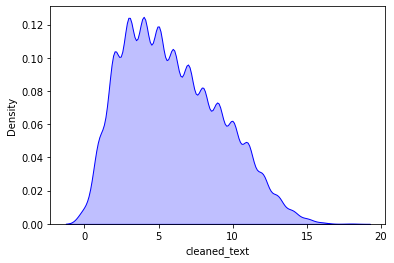

In [ ]:
## text 데이터의 길이의 분포 확인 -> text 자체의 길이가 그렇게 길지 않으므로 attention이 아닌 일반적인 rnn/lstm을 사용해도 될 듯 
train_text_len = train['cleaned_text'].apply(lambda x: len(str(x).split()))
text_len_plot = sns.kdeplot(train_text_len, shade=True, color="b")

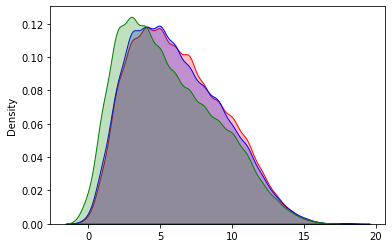

In [ ]:
# label 별 text 길이의 분포 -> label에 관계 없이 전체적으로 데이터가 5개의 단어로 이루어진 경우가 많음 
positive_text_len = train[train.sentiment=='positive'].apply(lambda x : len(x.cleaned_text.split()) ,axis=1)
negative_text_len = train[train.sentiment=='negative'].apply(lambda x : len(x.cleaned_text.split()),axis=1)
neutral_text_len = train[train.sentiment=='neutral'].apply(lambda x : len(x.cleaned_text.split()), axis=1)


positive_text_len_plot = sns.kdeplot(positive_text_len, shade=True, color='r')
negative_text_len = sns.kdeplot(negative_text_len, shade=True, color='b')
neutral_text_len = sns.kdeplot(neutral_text_len, shade=True, color='g')

In [ ]:
## 단어의 빈도수가 적은 경우 해당 단어가 결과에 영향을 미칠 가능성이 작기 때문에 
## 단어의 빈도수를 파악한 후 해당 단어를 제거해주는 게 좋음 
positive_text = train["cleaned_text"][train["sentiment"]=="positive"].apply(lambda x : x.split())
merged_positive_text = sum(positive_text, [])

negative_text = train["cleaned_text"][train["sentiment"]=="negative"].apply(lambda x: x.split())
merged_negative_text = sum(negative_text, [])

neutral_text = train["cleaned_text"][train["sentiment"]=="neutral"].apply(lambda x: x.split())
merged_neutral_text = sum(neutral_text, [])

In [ ]:
print(positive_text.iloc[0])
print(negative_text.iloc[0])

['feeding', 'baby', 'smile', 'coo']
['sooo', 'miss', 'diego']


In [ ]:
print(merged_positive_text)
print(merged_negative_text)
print(merged_neutral_text)

['feeding', 'baby', 'smile', 'coo', 'journey', 'became', 'cooler', 'hehe', 'possible', 'really', 'really', 'like', 'song', 'love', 'story', 'taylor', 'swift', 'playing', 'ghost', 'online', 'really', 'interesting', 'update', 'kirin', 'metamorph', 'third', 'cant', 'wait', 'dragon', 'free', 'fillin', 'ipod', 'addicted', 'juss', 'came', 'backk', 'berkeleyy', 'madd', 'havent', 'minute', 'whassqoodd', 'going', 'home', 'have', 'seen', 'twitter', 'design', 'quiteheavenly', 'hope', 'unni', 'make', 'audition', 'fighting', 'dahye', 'unni', 'thats', 'funny', 'cute', 'kid', 'little', 'happy', 'wine', 'jeje', 'itsm', 'free', 'time', 'care', 'jaja', 'love', 'avid', 'magazine', 'love', 'magazine', 'love', 'available', 'dear', 'would', 'love', 'help', 'convert', 'vidsï½', 'romance', 'zero', 'funny', 'what', 'better', 'spoil', 'kick', 'back', 'relax', 'nice', 'meal', 'bottle', 'favorite', 'wine', 'wine', 'awesome', 'have', 'worked', 'good', 'friend', 'chilliin', 'celticslakers', 'rematch', 'sound', 'bet

In [ ]:
word_num = 30

In [ ]:
import plotly.express as px

# positive sentiment의 twit에서 사용 되는 단어들의 빈도수 plot -> 한번만 쓰이는 단어가 거의 대부분을 차지함 -> 단어의 frequency를 바탕으로 쳐낼 단어를 고르면 너무 많은 단어를 없애게 됨 
#                                                              -> 다른 label과 공통으로 쓰이는 단어의 빈도수가 높다면 이를 제거해주는 게 좋음 
freq_pos = nltk.FreqDist(merged_positive_text)
positive_dataframe = pd.DataFrame({
    "words" : list(freq_pos.keys()),
    "count" : list(freq_pos.values())
})
common_pos = positive_dataframe.nlargest(columns="count", n=word_num)
print('전체 단어의 수 : ',len(positive_dataframe))
print('1번만 나타나는 단어의 수 : ',len(positive_dataframe[positive_dataframe["count"]==1]))
pos_figure = px.bar(common_pos, x="words", y="count", labels={"words" : "Words", "Count":"Frequency"})
pos_figure.show()

전체 단어의 수 :  10790
1번만 나타나는 단어의 수 :  7206


In [ ]:

##negative sentiment의 twit에서 사용 되는 단어들의 빈도수 plot -> 한번만 쓰이는 단어가 거의 대부분을 차지함 -> 이를 제거해주는 게 맞을 까? 아니면 그대로 두는게 맞을까?? -> 둘다 해보고 비교해야 할 듯 


freq_neg = nltk.FreqDist(merged_negative_text)
negative_dataframe = pd.DataFrame({
    "words" : list(freq_neg.keys()),
    "count" : list(freq_neg.values())
})
common_neg = negative_dataframe.nlargest(columns="count", n=word_num)
print('전체 단어의 수 : ',len(negative_dataframe))
print('1번만 나타나는 단어의 수 : ',len(negative_dataframe[negative_dataframe["count"]==1]))
neg_figure = px.bar(common_neg, x="words", y="count", labels={"words" : "Words", "Coun":"Frequency"})
neg_figure.show()

전체 단어의 수 :  10289
1번만 나타나는 단어의 수 :  6741


In [ ]:
freq_neu = nltk.FreqDist(merged_neutral_text)
neutral_dataframe = pd.DataFrame({
    "words" : list(freq_neu.keys()),
    "count" : list(freq_neu.values())
})
common_neu = neutral_dataframe.nlargest(columns="count", n=word_num)
print('전체 단어의 수 : ',len(neutral_dataframe))
print('한 번만 나타나는 단어의 수 : ',len(neutral_dataframe[neutral_dataframe["count"]==1]))
neu_figure = px.bar(common_neu, x="words", y="count", labels={"words":"Words", "Count":"Frequency"})
neu_figure.show()

전체 단어의 수 :  13400
한 번만 나타나는 단어의 수 :  8955


In [ ]:
## 겹치는 단어들을 다 제거하는게 맞을까? 아니면 상위 몇개만 제거하는게 맞을까??
## -> 겹치는 단어라도 이전에 어떤 단어들과 쓰였느냐에 따라 RNN에서의 출력값이 달라짐 따라서 겹친다고 무조건 제거하는것은 좋은 방법이 아닐 수 있음 
## 전체적으로 pos와 neg는 다른 점이 어느 정도 있지만 neu와 neg, neu와 pos는 비슷한 점이 많음 ->이를 활용할 수는 없을까??

pos_word_set=set([pos_word for pos_word in common_pos["words"]])
neg_word_set=set([neg_word for neg_word in common_neg["words"]])
neu_word_set=set([neu_word for neu_word in common_neu["words"]])

## positive와 negative가 겹치는 것 
pos_neg = pos_word_set & neg_word_set
print('positive와 negative가 겹치는 단어의 수의 비율: ', (len(pos_neg))/(len(pos_word_set | neg_word_set)))

## postivie와 neutral이 겹치는 것 
pos_neu = pos_word_set & neu_word_set
print('positive와 neutral의 겹치는 단어의 수의 비율: ', (len(pos_neu))/(len(pos_word_set | neu_word_set)))
## negative와 neutral이 겹치는 것 
neg_neu = neg_word_set & neu_word_set
print('neutral과 negative가 겹치는 단어의 수의 비율: ', (len(neg_neu))/(len(neu_word_set | neg_word_set)))




print('pos에서 겹치는 단어의 비율 : ',len(pos_neg|pos_neu)/len(pos_word_set))
print('neg에서 겹치는 단어의 비율 : ',len(neg_neu|pos_neg)/len(neg_word_set))
print('neu에서 겹치는 단어의 비율 : ',len(neg_neu|pos_neu)/len(neu_word_set))

positive와 negative가 겹치는 단어의 수의 비율:  0.2765957446808511
positive와 neutral의 겹치는 단어의 수의 비율:  0.3953488372093023
neutral과 negative가 겹치는 단어의 수의 비율:  0.5
pos에서 겹치는 단어의 비율 :  0.6
neg에서 겹치는 단어의 비율 :  0.7
neu에서 겹치는 단어의 비율 :  0.8333333333333334


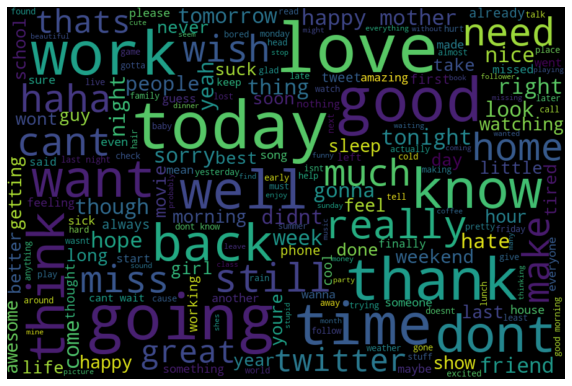

In [ ]:
## text에서 가장 많이 사용되는 단어 표현 2 - wordcloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = " ".join([text for text in train["cleaned_text"]])
wordclouds = WordCloud(width=900, height=600, random_state=42, max_font_size=110).generate(words)


plt.figure(figsize=(10,10))
plt.imshow(wordclouds, interpolation="bilinear")
plt.axis("off")
plt.show()

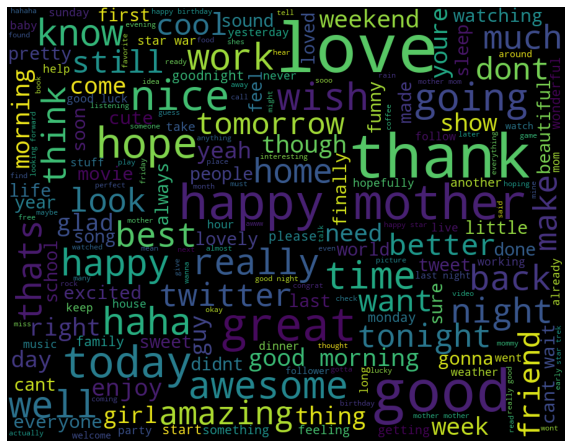

In [ ]:
words = " ".join([word for word in train["cleaned_text"][train["sentiment"]=="positive"]])
wordcloud_pos = WordCloud(width=900, height=700, random_state=42,max_font_size=110).generate(words)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.show()

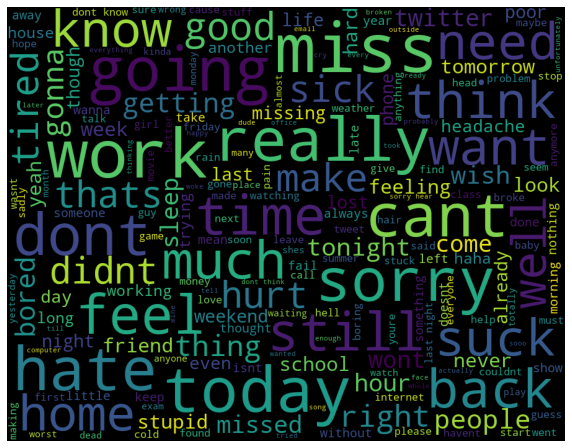

In [ ]:
words = " ".join([word for word in train["cleaned_text"][train["sentiment"]=="negative"]])
wordcloud_neg = WordCloud(width=900, height=700, random_state=42, max_font_size=110).generate(words)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.show()

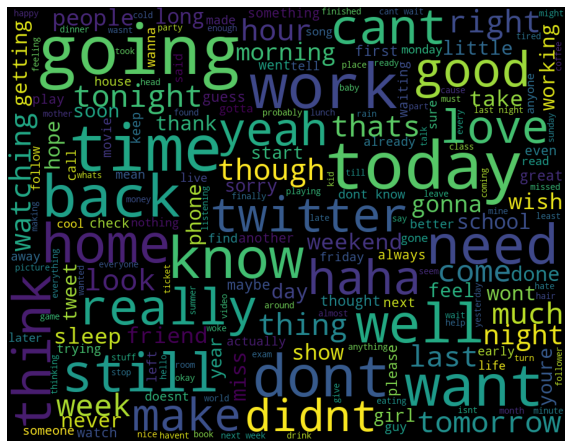

In [ ]:
words = " ".join([word for word in train["cleaned_text"][train["sentiment"]=="neutral"]])
wordcloud_neu = WordCloud(width=900, height= 700, random_state=42, max_font_size=110).generate(words)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_neu)
plt.axis("off")
plt.show()

In [ ]:
#Name Entity Recognition(개체명 인식)
# 이름을 가진 개체를 인식하는 것 -> 어떤 이름을 의미하는 단어를 보고 그 단어가 어떤 유형인지를 인식하는 것 
# 개체명 인식은 왜 필요한 거지?? -> 중요한 정보를 인식하고 식별하기 위함 

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
## 전체 label에 대한 entity 구하기 
ners = []
for text in train["cleaned_text"].values :
  doc = nlp(text)

  for entity in doc.ents:
    ners.append((entity.text, entity.label_))

In [ ]:
print(type(train["cleaned_text"].values))
print(type(train["cleaned_text"][train["sentiment"]=="positive"].values))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
## positive label에 대한 entity 구하기 
ners_pos = []
for text_pos in train["cleaned_text"][train["sentiment"]=="positive"].values : 
  doc_pos = nlp (text_pos)

  for entity_pos in doc_pos.ents:
    ners_pos.append((entity_pos.text, entity_pos.label_))

In [ ]:
## negative label에 대한 entity 구하기 
ners_neg = []
for text_neg in train["cleaned_text"][train["sentiment"]=="negative"].values:
  doc_neg = nlp(text_neg)

  for entity_neg in doc_neg.ents:
    ners_neg.append((entity_neg.text, entity_neg.label_))

In [ ]:
## neutral label에 댇한 entity 구하기 
ners_neu = []
for text_neu in train["cleaned_text"][train["sentiment"]=="neutral"].values:
  doc_neu = nlp(text_neu)

  for entity_neu in doc_neu.ents:
    ners_neu.append((entity_neu.text, entity_neu.label_))

In [ ]:
name_entity_df = pd.DataFrame(ners, columns=["Entity Name", "Entity Label"])
entity_df = name_entity_df.groupby(by=["Entity Name", "Entity Label"]).size().sort_values(ascending=False).reset_index().rename(columns={0:"Frequency"})

In [ ]:
name_entity_pos_df = pd.DataFrame(ners_pos, columns=["Entity Name", "Entity Label"])
entity_pos_df = name_entity_pos_df.groupby(by=["Entity Name", "Entity Label"]).size().sort_values(ascending=False).reset_index().rename(columns={0:"Frequency"})
entity_pos_date_df = entity_pos_df[entity_pos_df["Entity Label"]=="DATE"]
entity_pos_time_df = entity_pos_df[entity_pos_df["Entity Label"]=="TIME"]

In [ ]:
entity_pos_date_largest = entity_pos_date_df.nlargest(columns="Frequency",n=30)
entity_pos_time_largest = entity_pos_time_df.nlargest(columns="Frequency",n=30)

entity_pos_date_figure = px.bar(entity_pos_date_largest, x="Entity Name", y="Frequency", labels={"entity" : "Entity", "Frequency":"Frequency"})
entity_pos_time_figure = px.bar(entity_pos_time_largest, x="Entity Name", y="Frequency", labels={"entity" : "Entity", "Frequency":"Frequency"})

entity_pos_date_figure.show()
entity_pos_time_figure.show()

In [ ]:
name_entity_neg_df = pd.DataFrame(ners_neg, columns=["Entity Name", "Entity Label"])
entity_neg_df = name_entity_neg_df.groupby(by=["Entity Name", "Entity Label"]).size().sort_values(ascending=False).reset_index().rename(columns={0:"Frequency"})
entity_neg_date_df = entity_neg_df[entity_neg_df["Entity Label"]=="DATE"]
entity_neg_time_df = entity_neg_df[entity_neg_df["Entity Label"]=="TIME"]

In [ ]:
entity_neg_date_largest = entity_neg_date_df.nlargest(columns="Frequency",n=30)
entity_neg_time_largest = entity_neg_time_df.nlargest(columns="Frequency",n=30)

entity_neg_date_figure = px.bar(entity_neg_date_largest, x="Entity Name", y="Frequency", labels={"entity" : "Entity", "Frequency":"Frequency"})
entity_neg_time_figure = px.bar(entity_neg_time_largest, x="Entity Name", y="Frequency", labels={"entity" : "Entity", "Frequency":"Frequency"})

entity_neg_date_figure.show()
entity_neg_time_figure.show()

In [ ]:
name_entity_neu_df = pd.DataFrame(ners_neu, columns=["Entity Name","Entity Label"])
entity_neu_df = name_entity_neu_df.groupby(by=["Entity Name","Entity Label"]).size().sort_values(ascending=False).reset_index().rename(columns={0:"Frequency"})
entity_neu_date_df = entity_neg_df[entity_neu_df["Entity Label"]=="DATE"]
entity_neu_time_df = entity_neg_df[entity_neu_df["Entity Label"]=="TIME"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
entity_neu_date_largest = entity_neu_date_df.nlargest(columns="Frequency",n=30)
entity_neu_time_largest = entity_neu_time_df.nlargest(columns="Frequency",n=30)

entity_neu_date_figure = px.bar(entity_neu_date_largest, x="Entity Name", y="Frequency", labels={"entity" : "Entity", "Frequency":"Frequency"})
entity_neu_time_figure = px.bar(entity_neu_time_largest, x="Entity Name", y="Frequency", labels={"entity" : "Entity", "Frequency":"Frequency"})

entity_neu_date_figure.show()
entity_neu_time_figure.show()

In [ ]:
## 전체적으로 봤을 때 시간과 관련된 단어가 많이 사용 됨 

figure = px.bar(x=entity_df["Entity Label"][:50], y=entity_df["Frequency"][:50])
figure.show()

In [ ]:
figure_pos = px.bar(x=entity_pos_df["Entity Label"][:50], y=entity_df["Frequency"][:50])
figure_pos.show()

In [ ]:
figure_neg = px.bar(x=entity_neg_df["Entity Label"][:50], y=entity_df["Frequency"][:50])
figure_neg.show()

In [ ]:
figure_neu = px.bar(x=entity_neu_df["Entity Label"][:50], y=entity_df["Frequency"][:50])
figure_neu.show()

In [ ]:
## Topic Modelling 
texts = train["cleaned_text"].apply(lambda x : x.split())
texts.head()

0                          [responded, going]
1                         [sooo, miss, diego]
2                             [bos, bullying]
3                   [interview, leave, alone]
4    [son, couldnt, release, already, bought]
Name: cleaned_text, dtype: object

In [ ]:
# Build the dictionary of words from the document 
from gensim import corpora 
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# Build the LDA Model (Lantent Dirichlet Allocation : corpus로 부터 topic을 추출하는 방법)
# LDA = 주어진 문서에 대하여 각 문서에 어떤 주제들이 존재하는지에 대한 확률 모형 
# LDA는 주제별 단어의 분포, 문서별 주제의 분포를 모두 추정해 냄 

import gensim 
topics = 3 
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=topics, id2word=dictionary, passes=15)
lda.save("LDA_model.gensim")

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 4.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=7fe74975c098227b3b0211f17225e1d00e80c028b90ec3d329b8a49a78147a65
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.gensim

display = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(display)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

